![](http://)**Detecting Pneumonia in X-Ray Images**

Using data from http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

![](https://i.imgur.com/jZqpV51.png)

Figure S6. Illustrative Examples of Chest X-Rays in Patients with Pneumonia, Related to Figure 6
The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.
http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5



*Step 1: Import Modules*

In [1]:
import os
import pickle
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization

from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

*Step 2: Load Data*

In [5]:
train_dir = r"C:\Users\Competitif Prog\Desktop\pfa\chest_xray/train/"
test_dir = r"C:\Users\Competitif Prog\Desktop\pfa\chest_xray/test/"
def get_data(folder):
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (150, 150, 3))
                    
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
X_train, y_train = get_data(train_dir)
X_test, y_test= get_data(test_dir)

100%|██████████| 390/390 [00:34<00:00, 11.20it/s]


*Step 3: Vizualize Data*

The min/max pixel values are already scaled between 0 and 1

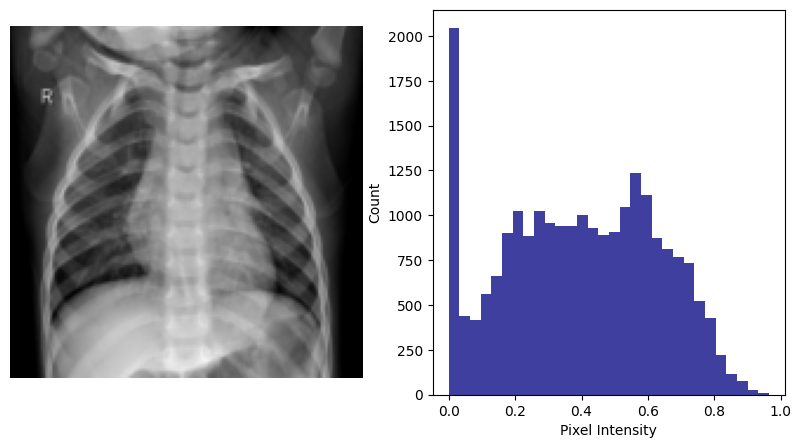

In [13]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

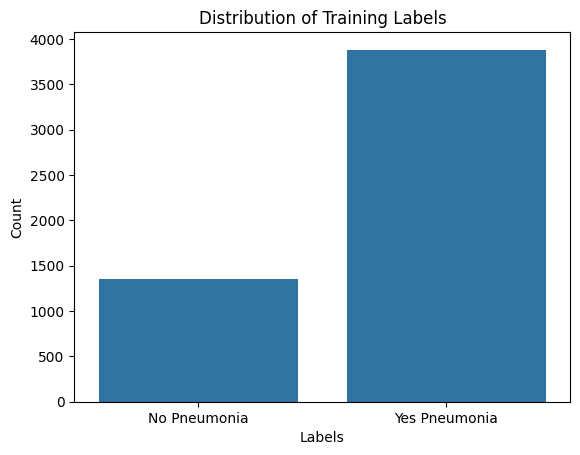

In [35]:
map_characters = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}



# Create a DataFrame from y_train
df = pd.DataFrame()
df["labels"] = y_train

# Plot the distribution using seaborn
sns.countplot(x=df["labels"])
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Training Labels')
plt.xticks(ticks=[0, 1], labels=[map_characters[0], map_characters[1]])
plt.show()

*Step 4: Define Helper Functions*

In [4]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


    

*Step 5: Evaluate Classification Models*

Transfer learning w/ VGG16 Convolutional Network

In [5]:
map_characters1 = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}
class_weight1 = class_weight.compute_class_weight(class_weight ="balanced",classes=np.unique(y_train),y= y_train)
weight_path1 = r'C:\Users\Competitif Prog\Desktop\pfa\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
weight_path2 = r'C:\Users\Competitif Prog\Desktop\pfa\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model_1 = VGG16(weights = weight_path1, include_top=False, input_shape=(150, 150, 3))
pretrained_model_2 = InceptionV3(weights = weight_path2, include_top=False, input_shape=(150, 150, 3))
optimizer1 = keras.optimizers.RMSprop(learning_rate=0.0001)


In [19]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)
        
def plot_learning_curve(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [18]:
def pretrainedNetwork(xtrain,ytrain,xtest,ytest,pretrainedmodel,pretrainedweights,classweight,numclasses,numepochs,optimizer,labels):
    base_model = pretrainedmodel # Topless
    # Add top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(numclasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
    optimizer = optimizer
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    # Fit model
    history = model.fit(xtrain,ytrain, epochs=numepochs, class_weight=classweight, validation_data=(xtest,ytest), verbose=1,callbacks = [MetricsCheckpoint('logs')])

    model.save('pretrained_'+str(pretrainedmodel.name)+'.h5')
    # Evaluate model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(ytest,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
    plt.show()

    
    return model
#pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_1,weight_path1,class_weight1,2,3,optimizer1,map_characters1)

In [8]:
# Encode labels to hot vectors (ex : 1 -> [0,1])

y_trainHot = to_categorical(y_train, num_classes = 2)
y_testHot = to_categorical(y_test, num_classes = 2)


*Step 6: Evaluate Undersampling Strategy*

The goal is to get rid of the class imbalance issues.  Oversampling with data augmentation (e.g. [SMOTE](http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html)) would be preferable to undersampling but undersampling is faster.

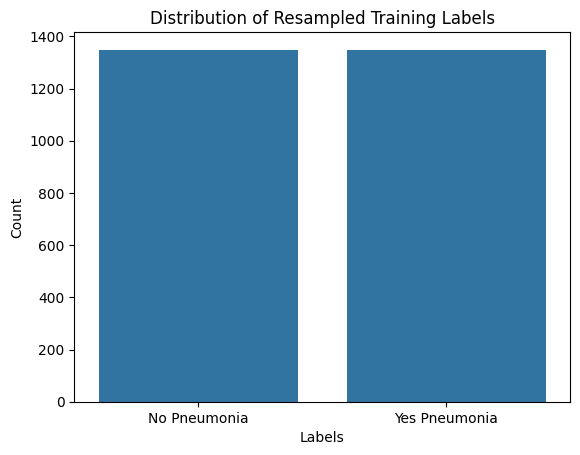

{0: 'No Pneumonia', 1: 'Yes Pneumonia'}


In [9]:
map_characters = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}
X_trainShape = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]
X_testShape = X_test.shape[1] * X_test.shape[2] * X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = y_train
Y_test = y_test

# Apply RandomUnderSampler
ros = RandomUnderSampler(sampling_strategy='auto')
X_trainRos, Y_trainRos = ros.fit_resample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_resample(X_testFlat, Y_test)

# Encode labels to one-hot vectors (e.g., 2 -> [0, 1])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes=2)
Y_testRosHot = to_categorical(Y_testRos, num_classes=2)

# Make Data 2D again
height, width, channels = 150, 150, 3
X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos), height, width, channels)
X_testRosReshaped = X_testRos.reshape(len(X_testRos), height, width, channels)

# Plot Label Distribution
dfRos = pd.DataFrame()
dfRos["labels"] = Y_trainRos

# Plot the distribution using seaborn
sns.countplot(x=dfRos['labels'])
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Resampled Training Labels')
plt.xticks(ticks=[0, 1], labels=[map_characters[0], map_characters[1]])
plt.show()

# Print the dictionary mapping
print(map_characters)

In [10]:
class_weight1 = class_weight.compute_class_weight(class_weight ="balanced",classes=np.unique(Y_train),y= Y_train)
print("Old Class Weights: ",class_weight1)
class_weights1_dict = {0: class_weight1[0], 1: class_weight1[1]}
class_weight2 = class_weight.compute_class_weight(class_weight ="balanced",classes=np.unique(Y_trainRos),y= Y_trainRos)
class_weights2_dict = {0: class_weight2[0], 1: class_weight2[1]}
print("New Class Weights: ",class_weight2)

Old Class Weights:  [1.93921423 0.6737059 ]
New Class Weights:  [1. 1.]


Traning the VGG16 model using class_weights(No undersampling)

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │        16,386 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,731,074 (56.19 MB)

 Trainable params: 16,386 (64.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/6
164/164 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.8155 - loss: 0.4774 - val_accuracy: 0.8670 - val_loss: 0.3341
Epoch 2/6
164/164 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.9432 - loss: 0.1820 - val_accuracy: 0.8766 - val_loss: 0.2971
Epoch 3/6
164/164 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.9549 - loss: 0.1351 - val_accuracy: 0.8413 - val_loss: 0.3553
Epoch 4/6
164/164 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.9524 - loss: 0.1245 - val_accuracy: 0.8446 - val_loss: 0.3549
Epoch 5/6
164/164 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.9640 - loss: 0.1046 - val_accuracy: 0.8462 - val_loss: 0.3562
Epoch 6/6
164/164 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.9672 - loss: 0.0930 - val_accuracy: 0.8381 - val_loss: 0.3792



Keras CNN - accuracy: 0.8381410241127014 

20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

               precision    recall  f1-score   support

 No Pneumonia       0.97      0.59      0.73       234
Yes Pneumonia       0.80      0.99      0.88       390

     accuracy                           0.84       624
    macro avg       0.88      0.79      0.81       624
 weighted avg       0.86      0.84      0.83       624



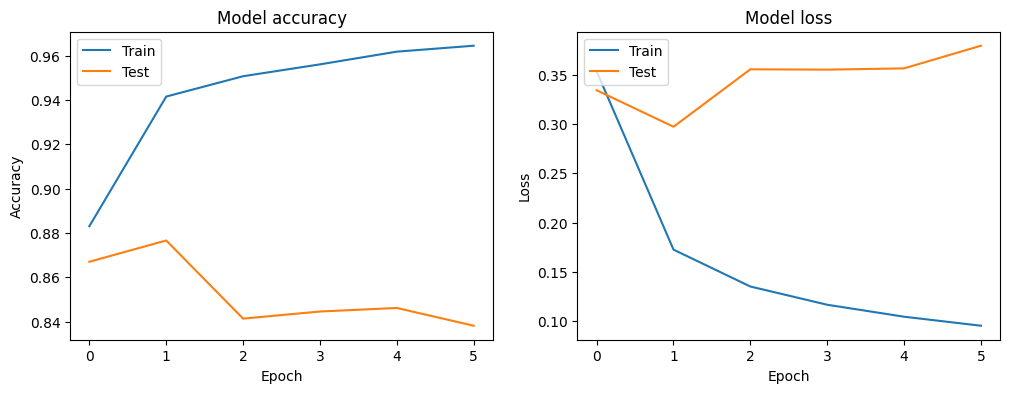

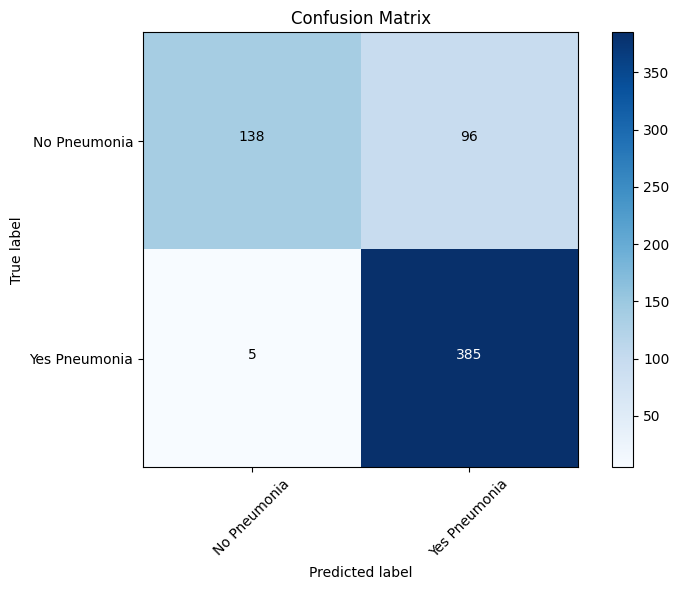

In [42]:
optimizer1 = keras.optimizers.RMSprop(learning_rate=0.0001)
modelVGG=pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_1,weight_path1,class_weights1_dict,2,6,optimizer1,map_characters1)


*Step 7: Evaluate Final Model*

Transfer learning w/ VGG16 Convolutional Network

Traning The VGG16 Model Using Undersampling

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │        16,386 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,731,074 (56.19 MB)

 Trainable params: 16,386 (64.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.7506 - loss: 0.5659 - val_accuracy: 0.8718 - val_loss: 0.4027
Epoch 2/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.9294 - loss: 0.2614 - val_accuracy: 0.8291 - val_loss: 0.3736
Epoch 3/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9415 - loss: 0.1881 - val_accuracy: 0.8098 - val_loss: 0.4149
Epoch 4/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9525 - loss: 0.1441 - val_accuracy: 0.8098 - val_loss: 0.4225
Epoch 5/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.9598 - loss: 0.1335 - val_accuracy: 0.8141 - val_loss: 0.4188
Epoch 6/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.9646 - loss: 0.1086 - val_accuracy: 0.8184 - val_loss: 0.4005



Keras CNN - accuracy: 0.8183760643005371 

15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step

               precision    recall  f1-score   support

 No Pneumonia       0.97      0.66      0.78       234
Yes Pneumonia       0.74      0.98      0.84       234

     accuracy                           0.82       468
    macro avg       0.85      0.82      0.81       468
 weighted avg       0.85      0.82      0.81       468



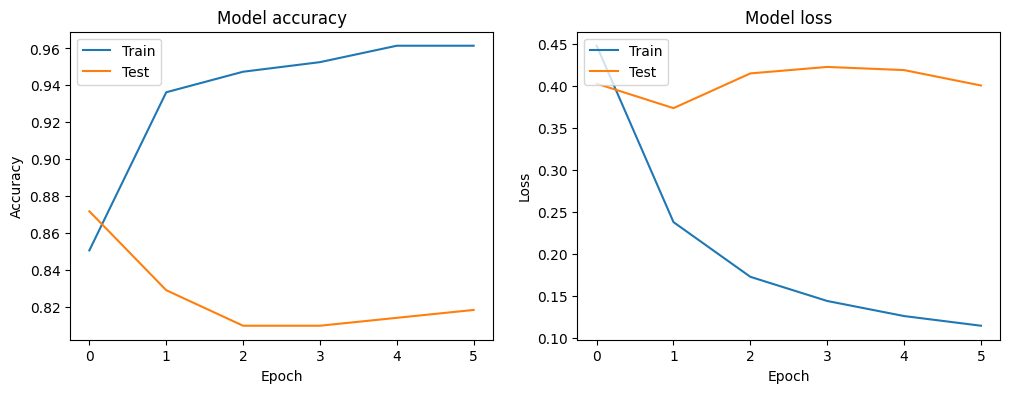

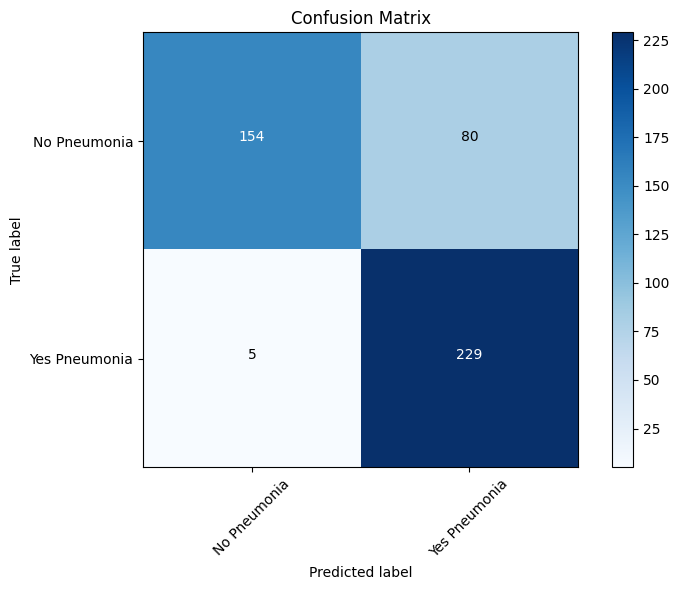

In [15]:
optimizer1 = keras.optimizers.RMSprop(learning_rate=0.0001)
modelVGG_ROS=pretrainedNetwork(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,pretrained_model_1,weight_path1,class_weights2_dict,2,6,optimizer1,map_characters1)

Transfer learning w/ InceptionV3 Convolutional Network

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 21,839,650 (83.31 MB)

 Trainable params: 36,866 (144.01 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 47s 462ms/step - accuracy: 0.7755 - loss: 0.7548 - val_accuracy: 0.8248 - val_loss: 0.5684
Epoch 2/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 477ms/step - accuracy: 0.9238 - loss: 0.2022 - val_accuracy: 0.7671 - val_loss: 0.8377
Epoch 3/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 413ms/step - accuracy: 0.9645 - loss: 0.1106 - val_accuracy: 0.7842 - val_loss: 0.7526
Epoch 4/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 409ms/step - accuracy: 0.9574 - loss: 0.1104 - val_accuracy: 0.7500 - val_loss: 1.1256
Epoch 5/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 484ms/step - accuracy: 0.9679 - loss: 0.0882 - val_accuracy: 0.7714 - val_loss: 1.0088
Epoch 6/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 423ms/step - accuracy: 0.9707 - loss: 0.0714 - val_accuracy: 0.7949 - val_loss: 0.8829



Keras CNN - accuracy: 0.7948718070983887 

15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 496ms/step

               precision    recall  f1-score   support

 No Pneumonia       0.97      0.61      0.75       234
Yes Pneumonia       0.72      0.98      0.83       234

     accuracy                           0.79       468
    macro avg       0.84      0.79      0.79       468
 weighted avg       0.84      0.79      0.79       468



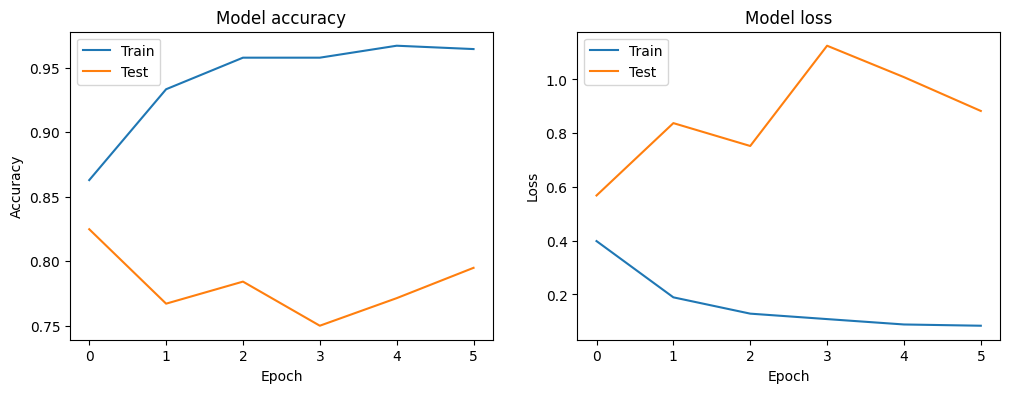

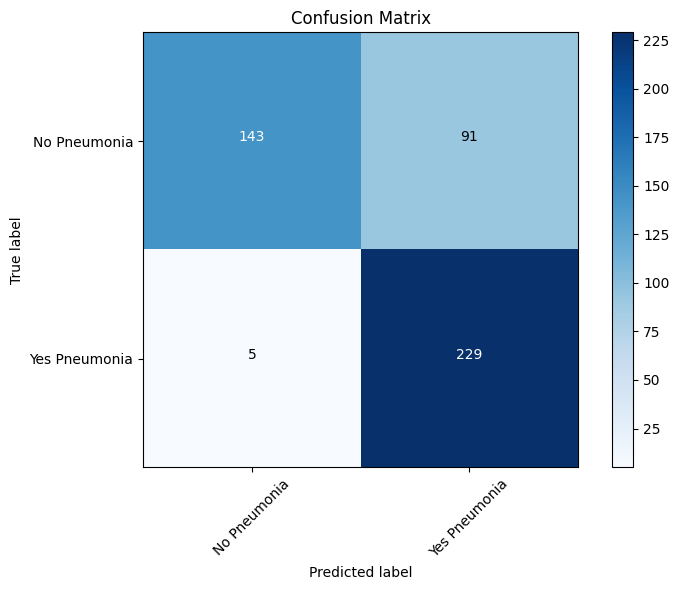

In [14]:


optimizer1 = keras.optimizers.RMSprop(learning_rate=0.0001)
InceptionModel=pretrainedNetwork(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,pretrained_model_2,weight_path2,class_weights2_dict,2,6,optimizer1,map_characters1)


 We were able to detect pneumonia in x-ray images with an accuracy rate of approximately 85%.  Great!

To Do: (1) Add data augmentation; (2) Add ROC curve; (3) 

Building CNN from scratch

In [21]:
optimizer1 = keras.optimizers.RMSprop(learning_rate=0.0001)

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
def build_and_train_CNN(xtrain, ytrain, xtest, ytest, input_shape, num_classes, class_weight, num_epochs, optimizer, labels):
    # Define the CNN architecture
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    # Print model summary
    model.summary()
    
    # Callbacks
    callbacks_list = [EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)]
    
    # Fit the model
    history = model.fit(xtrain, ytrain, epochs=num_epochs, class_weight=class_weight, validation_data=(xtest, ytest), verbose=1, callbacks=callbacks_list)
    
    # Save the model
    model.save('cnn_model_final.h5')
    
    # Evaluate the model
    score = model.evaluate(xtest, ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    
    # Predict
    y_pred = model.predict(xtest)
    print('\n', classification_report(np.argmax(ytest, axis=1), np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='')
    
    # Confusion matrix
    Y_pred_classes = np.argmax(y_pred, axis=1)
    Y_true = np.argmax(ytest, axis=1)
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    
    # Plotting functions
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes=list(labels.values()))
    plt.show()
    
    return model



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_100 (Conv2D)             │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,610 (18.42 MB)

 Trainable params: 4,828,610 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 33s 348ms/step - accuracy: 0.6270 - loss: 0.6501 - val_accuracy: 0.5000 - val_loss: 0.7818
Epoch 2/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 30s 349ms/step - accuracy: 0.8169 - loss: 0.4510 - val_accuracy: 0.8440 - val_loss: 0.3852
Epoch 3/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 28s 327ms/step - accuracy: 0.8924 - loss: 0.2974 - val_accuracy: 0.7885 - val_loss: 0.4124
Epoch 4/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 29s 336ms/step - accuracy: 0.9128 - loss: 0.2336 - val_accuracy: 0.8269 - val_loss: 0.3749
Epoch 5/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 27s 317ms/step - accuracy: 0.9331 - loss: 0.1829 - val_accuracy: 0.8590 - val_loss: 0.3345
Epoch 6/6
85/85 ━━━━━━━━━━━━━━━━━━━━ 27s 315ms/step - accuracy: 0.9421 - loss: 0.1551 - val_accuracy: 0.7650 - val_loss: 0.5145



Keras CNN - accuracy: 0.7649572491645813 

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step

               precision    recall  f1-score   support

 No Pneumonia       0.92      0.58      0.71       234
Yes Pneumonia       0.69      0.95      0.80       234

     accuracy                           0.76       468
    macro avg       0.81      0.76      0.76       468
 weighted avg       0.81      0.76      0.76       468



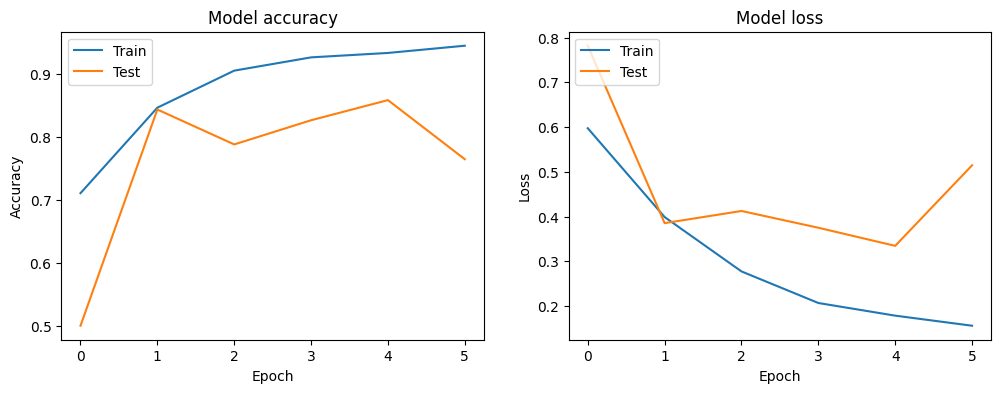

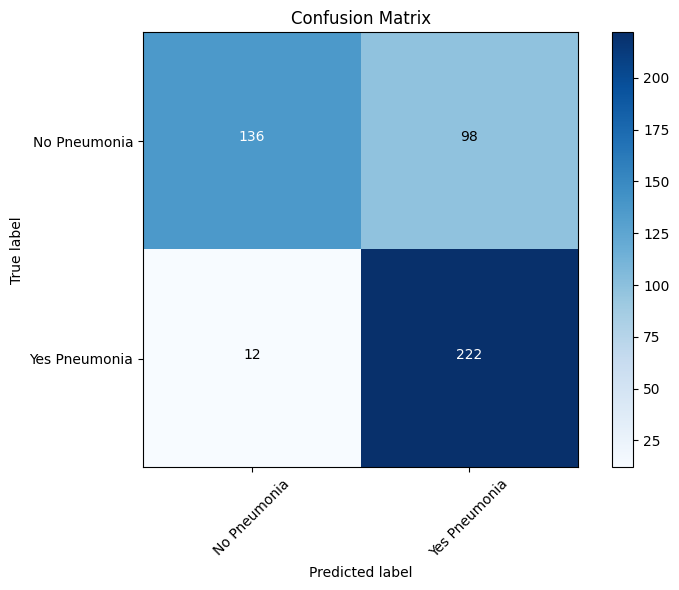

In [22]:
CNN=build_and_train_CNN(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot, (150, 150, 3), 2, class_weights2_dict, 6, optimizer1, map_characters1)


Ploting the ROC-Curve

In [39]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Function to plot the ROC curve
def plot_roc_curve(models,labels):
    plt.figure(figsize=(10, 8))
    for model, label in zip(models, labels):
        y_pred_prob = model.predict(X_testRosReshaped)
        
        # If y_test and y_pred_prob are one-hot encoded, convert them to single labels
        y_test_labels = np.argmax(Y_testRosHot, axis=1)
        y_pred_prob = y_pred_prob[:, 1] 

        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 346ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


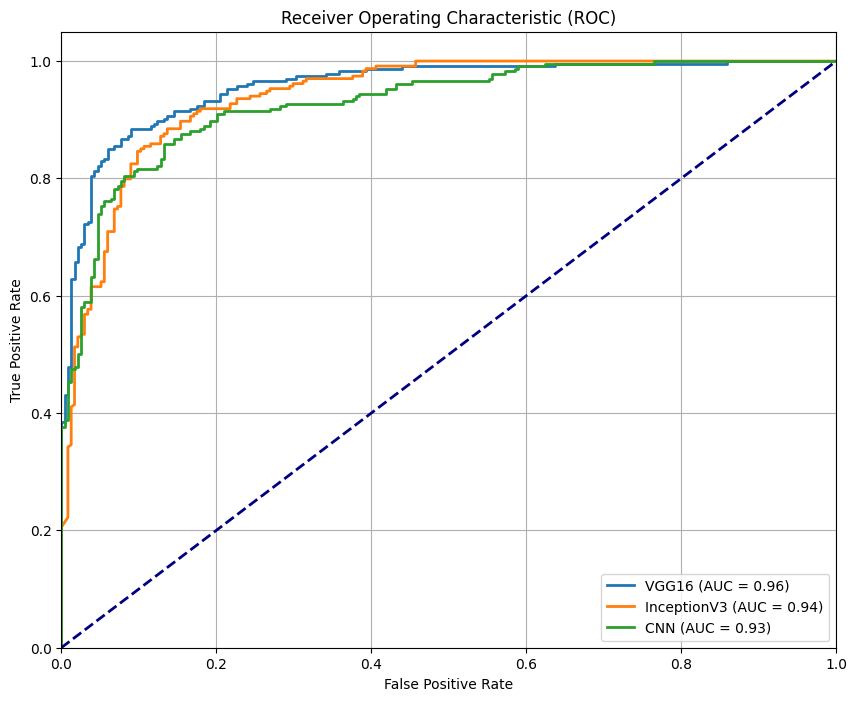

In [44]:
models = [modelVGG_ROS, InceptionModel, CNN]
labels = ['VGG16', 'InceptionV3', 'CNN']
plot_roc_curve(models,labels)